In [1]:
import numpy as np
import pandas as pd
import pandas_datareader as pdr
import math
import  matplotlib.pyplot as plt
from  tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler


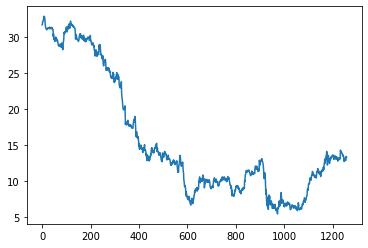

In [2]:
data=pdr.get_data_tiingo('GE', api_key='ae0f631f91fa6003822cdbb33a1d5ce8af02e41c')
data.to_csv('GE.csv')
#data.head()

df=pd.read_csv('GE.csv')
plt.plot(df['close'])
plt.show()

In [3]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GE,2016-07-06 00:00:00+00:00,31.74,31.80,31.265,31.27,32095930,27.995582,28.048504,27.576619,27.581029,33361343,0.0,1.0
1,GE,2016-07-07 00:00:00+00:00,31.82,32.10,31.740,31.81,37517858,28.066144,28.313112,27.995582,28.057324,38997036,0.0,1.0
2,GE,2016-07-08 00:00:00+00:00,32.20,32.27,31.990,31.99,38531744,28.401315,28.463057,28.216089,28.216089,40050895,0.0,1.0
3,GE,2016-07-11 00:00:00+00:00,32.21,32.50,32.180,32.26,37977863,28.410135,28.665924,28.383675,28.454237,39475177,0.0,1.0
4,GE,2016-07-12 00:00:00+00:00,32.26,32.49,32.130,32.31,38082951,28.454237,28.657103,28.339573,28.498338,39584408,0.0,1.0


In [4]:
# Spearating Datas for future processing
train_dates=pd.to_datetime(df['date'])
train_dates

0      2016-07-06 00:00:00+00:00
1      2016-07-07 00:00:00+00:00
2      2016-07-08 00:00:00+00:00
3      2016-07-11 00:00:00+00:00
4      2016-07-12 00:00:00+00:00
                  ...           
1253   2021-06-28 00:00:00+00:00
1254   2021-06-29 00:00:00+00:00
1255   2021-06-30 00:00:00+00:00
1256   2021-07-01 00:00:00+00:00
1257   2021-07-02 00:00:00+00:00
Name: date, Length: 1258, dtype: datetime64[ns, UTC]

In [5]:
#cols for training
datacols=list(df)[2:8]
datacols

['close', 'high', 'low', 'open', 'volume', 'adjClose']

In [6]:
cols=['close', 'high', 'low', 'open','adjClose']

In [7]:
len(df)

1258

In [8]:
df_for_training=df[cols].astype(float)
df_for_training


,close,high,low,open,adjClose
0,31.74,31.800,31.265,31.27,27.995582
1,31.82,32.100,31.740,31.81,28.066144
2,32.20,32.270,31.990,31.99,28.401315
3,32.21,32.500,32.180,32.26,28.410135
4,32.26,32.490,32.130,32.31,28.454237
...,...,...,...,...,...
1253,12.89,13.170,12.790,13.16,12.890000
1254,13.09,13.230,12.960,13.06,13.090000
1255,13.46,13.525,13.050,13.15,13.460000
1256,13.48,13.630,13.360,13.58,13.480000


In [9]:
#Normalization of data set
# LSTM use sigmoid and tanh functions. These functions are sensitive to magnitude
#so values are normalized in the data set

scaler=StandardScaler()
scaler=scaler.fit(df_for_training)
df_for_training_scaled=scaler.transform(df_for_training)
df_for_training_scaled

array([[ 1.91207214,  1.89621193,  1.87626956,  1.85318473,  1.8515544 ],
       [ 1.92161676,  1.93198964,  1.9329691 ,  1.91759287,  1.8613741 ],
       [ 1.9669537 ,  1.95226368,  1.96281096,  1.93906225,  1.90801766],
       ...,
       [-0.26887347, -0.28324692, -0.2980085 , -0.30806617, -0.17126882],
       [-0.26648732, -0.27072472, -0.26100459, -0.25677821, -0.16848555],
       [-0.28080425, -0.28145803, -0.26697296, -0.26154918, -0.18518518]])

In [10]:
trainX=[]
trainY=[]
n_future=1  # number of days we want to predict into the future
n_past=14   # Number of past days data we want to use to predict the future


In [11]:
for i in range(n_past,len(df_for_training_scaled)-n_future+1):
    trainX.append(df_for_training_scaled[i-n_past:i,:df_for_training.shape[1]])
    trainY.append(df_for_training_scaled[i+n_future -1:i+n_future,0])

trainX,trainY = np.array(trainX), np.array(trainY)

In [12]:
trainX[0:1],trainY[0:1]

(array([[[1.91207214, 1.89621193, 1.87626956, 1.85318473, 1.8515544 ],
         [1.92161676, 1.93198964, 1.9329691 , 1.91759287, 1.8613741 ],
         [1.9669537 , 1.95226368, 1.96281096, 1.93906225, 1.90801766],
         [1.96814678, 1.97969326, 1.98549078, 1.97126632, 1.90924512],
         [1.97411217, 1.97850066, 1.9795224 , 1.97723003, 1.91538243],
         [1.98604294, 1.97730807, 1.9938465 , 1.97126632, 1.92765705],
         [2.01825603, 2.00593024, 2.02249469, 1.99989216, 1.96079853],
         [2.04808297, 2.03335982, 2.05233655, 2.03090348, 1.99148508],
         [2.0516622 , 2.03216723, 2.04278715, 2.04640915, 1.99516747],
         [2.05404836, 2.03335982, 2.0499492 , 2.02971074, 1.99762239],
         [2.03615219, 2.03932277, 2.04756185, 2.05475835, 1.97921046],
         [2.01348372, 2.02143392, 2.02249469, 2.02732525, 1.95588868],
         [1.95025062, 1.92841187, 1.92700073, 1.90805092, 1.89083319],
         [1.90014136, 1.92960446, 1.88999682, 1.9486042 , 1.83927978]]]),
 ar

In [13]:
trainX.shape[1],trainX.shape[2]

(14, 5)

In [14]:
trainY.dtype

dtype('float64')

In [15]:
model=Sequential()
model.add(LSTM(64,activation='relu',input_shape=(trainX.shape[1],trainX.shape[2]),return_sequences=True))
model.add(LSTM(64,activation='relu',return_sequences=False))
#model.add(Dropout(0,2))# Enabling this craetes some type error
model.add(Dense(trainY.shape[1]))
model.compile(optimizer='adam',loss='mse')
model.summary()



Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 14, 64)            17920     
_________________________________________________________________
lstm_1 (LSTM)                (None, 64)                33024     
_________________________________________________________________
dense (Dense)                (None, 1)                 65        
Total params: 51,009
Trainable params: 51,009
Non-trainable params: 0
_________________________________________________________________


In [16]:
hsitory=model.fit(trainX,trainY,epochs=100,batch_size=16,validation_split=0.1,verbose=1)

Epoch 1/100
70/70 [==============================] - 4s 11ms/step - loss: 0.1677 - val_loss: 0.0030
Epoch 2/100
70/70 [==============================] - 1s 7ms/step - loss: 0.0080 - val_loss: 0.0040
Epoch 3/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0057 - val_loss: 0.0039
Epoch 4/100
70/70 [==============================] - 1s 7ms/step - loss: 0.0052 - val_loss: 0.0041
Epoch 5/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0055 - val_loss: 0.0027
Epoch 6/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 7/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0046 - val_loss: 0.0025
Epoch 8/100
70/70 [==============================] - 1s 7ms/step - loss: 0.0037 - val_loss: 0.0022
Epoch 9/100
70/70 [==============================] - 1s 8ms/step - loss: 0.0033 - val_loss: 0.0022
Epoch 10/100
70/70 [==============================] - 1s 8ms/step - loss: 0.0032 - val_loss: 0.0021
Epoch 11

70/70 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 84/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0016 - val_loss: 0.0012
Epoch 85/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0011
Epoch 86/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 87/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0014
Epoch 88/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0013
Epoch 89/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 90/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 91/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 92/100
70/70 [==============================] - 0s 7ms/step - loss: 0.0015 - val_loss: 0.0012
Epoch 93/100


G:\ANACONDA_INSTALLATION\lib\site-packages\ipykernel_launcher.py:1: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  """Entry point for launching an IPython kernel.
G:\ANACONDA_INSTALLATION\lib\site-packages\ipykernel_launcher.py:2: MatplotlibDeprecationWarning: Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
  


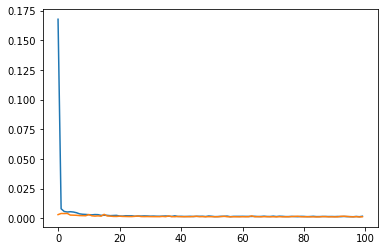

In [17]:
plt.plot(hsitory.history['loss'],Label='Training loss')
plt.plot(hsitory.history['val_loss'],Label='Validaiton loss')
plt.show()

In [32]:
#Forcasting
#We will start with the last day in the training date and predict future
n_future1=90
forecast_period_dates=pd.date_range(list(train_dates)[-1],periods=n_future1,freq='1d').tolist()
forecast=model.predict(trainX[-n_future1:])
# inverse scaling is to be performed to get th eoriginal values
# we have used 5 variables for transformation, inverse transformation also should 
# be of same dimensions
forecast_copies=np.repeat(forecast,df_for_training.shape[1],axis=1)
y_pred_future=scaler.inverse_transform(forecast_copies)[:,0]

y_pred_future.shape

(90,)

In [35]:
#converting timestamp to date
forecast_dates=[]
for time_i in forecast_period_dates:
    forecast_dates.append(time_i.date())
df_forecast=pd.DataFrame({'Date':np.array(forecast_dates),'open':y_pred_future})
df_forecast['Date']=pd.to_datetime(df_forecast['Date'])                         


G:\ANACONDA_INSTALLATION\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\NIDUR\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\NIDUR\AppData\Roaming\Python\Python37\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `d

<AxesSubplot:xlabel='date', ylabel='open'>

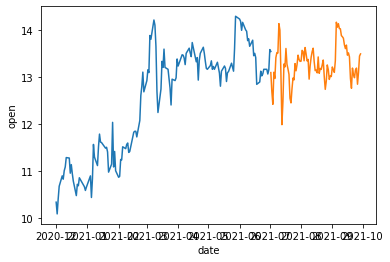

In [43]:
import seaborn as sns
original=df[['date' ,'open']]
original['date']=pd.to_datetime(original['date'])
original=original.loc[original['date'] >= '2020-12-1']
sns.lineplot(original['date'],original['open'])
sns.lineplot(df_forecast['Date'],df_forecast['open'])


In [37]:
df.head()

,symbol,date,close,high,low,open,volume,adjClose,adjHigh,adjLow,adjOpen,adjVolume,divCash,splitFactor
0,GE,2016-07-06 00:00:00+00:00,31.74,31.80,31.265,31.27,32095930,27.995582,28.048504,27.576619,27.581029,33361343,0.0,1.0
1,GE,2016-07-07 00:00:00+00:00,31.82,32.10,31.740,31.81,37517858,28.066144,28.313112,27.995582,28.057324,38997036,0.0,1.0
2,GE,2016-07-08 00:00:00+00:00,32.20,32.27,31.990,31.99,38531744,28.401315,28.463057,28.216089,28.216089,40050895,0.0,1.0
3,GE,2016-07-11 00:00:00+00:00,32.21,32.50,32.180,32.26,37977863,28.410135,28.665924,28.383675,28.454237,39475177,0.0,1.0
4,GE,2016-07-12 00:00:00+00:00,32.26,32.49,32.130,32.31,38082951,28.454237,28.657103,28.339573,28.498338,39584408,0.0,1.0
